# Security Log Tutorial

Logging can be a really effective tool for making information about actions taken in a software easy to access and analyse. We wanted to create a logging feature specifically to track the actions performed on your RemoteLazyFrame datasets. This makes it easy for data owners to track exactly what actions any users with access have taken or requested in relation to their datasets.

In this tutorial, we are going to take a look at how to access your security log dataframe in `BastionLab` and how you can query your log dataframe to access the exact information you are interested in. But before we dive into that, let's get everything set up!

## BastionLab's installation

>You'll need Python and Docker installed on your machine to run this tutorial. You can refer to our [Installation section](https://bastionlab.readthedocs.io/en/latest/docs/tutorials/installation/) to check the specific technical requirements needed by BastionLab's Client and Server, as well as other methods to install them if the following ones are not for you. 

### BastionLab Client and Polars installation

In [48]:
! pip install polars
! pip install bastionlab

### BastionLab Server 
#### using the official docker image

In [49]:
!docker pull mithrilsecuritysas/bastionlab:latest

## Setting up the keys

In this tutorial, we are going to create three authenticated users: the data owner, data_scientist_1 and data_scientist_2 using BastionLab's `Identity` module. This will help us to illustrate how the security log can track different users' actions.

For a more detailed walk-through of authentication, check out our [authentication tutorial]().

> *Note* - The keys generated by the `Identity` class are placed in the current working directory.

In [50]:
from bastionlab import Identity

# Create `Identity` for Data owner.
data_owner = Identity.create("data_owner")

# Create `Identity` for Data Scientists 1 and 2.
data_scientist_1 = Identity.create("data_scientist_1")
data_scientist_2 = Identity.create("data_scientist_2")

Now that now we have setup our identities, we will have to start the server with the **public keys** of the data owner and the data scientists.

> *Note* - This step will have to be done by the party setting up the server, commonly the **data owner**. They will have to get all the public keys of the interested parties.

### Setting up the keys directory

We will now set up the `keys` directory that the server will use to verify users.

We will use the following default schema:

```sh
keys/
├─ owners/
├─ users/
```

In [51]:
!mkdir -p keys/owners keys/users

We can now copy the public keys of the data owner and data scientists into the revelant sub-directories.

In [52]:
!cp data_owner.pub keys/owners
!cp data_scientist_1.pub keys/users
!cp data_scientist_2.pub keys/users

### Starting BastionLab Server with public keys

Finally, we can launch the server with our keys directory.

In [53]:
!docker run -it -p 50056:50056 -v $(pwd)/keys:/app/bin/keys mithrilsecuritysas/bastionlab:latest

## Data owner: uploading datasets



So now that all the set-up, let's start by putting ourselves into the shoes of the data owner.

Let's start by connecting to the server!

We open an authenticated connection to the server by providing its hostname and the identity:

In [54]:
from bastionlab import Connection

connection = Connection("localhost", identity=data_owner)
client = connection.client

Next, we will create there Polars dataframes and send them to the server.

In [55]:
import polars as pl

df1 = pl.DataFrame(
    {
        "Quarter": ["Q1", "Q2", "Q3", "Q4"],
        "Sales": [100000, 150000, 75000, 200000],
    }
)

df2 = pl.DataFrame({"Name": ["Laura", "Maya"], "Age": [29, 33]})

df3 = pl.DataFrame({"Element": ["Titanium"], "Melting Point (K)": [1945.0]})

rdf1 = client.polars.send_df(df1)
rdf2 = client.polars.send_df(df2)
rdf3 = client.polars.send_df(df3)

We can view a list of the dataframes that have been uploaded to the sever by using the `list_dfs()` method.

I am also going to grab hold of the identifiers for each uplaoded dataframe at this point- we will use these later on.

In [56]:
RDF1 = rdf1.identifier
RDF2 = rdf2.identifier
RDF3 = rdf3.identifier

all_rdfs = client.polars.list_dfs()
all_rdfs

[FetchableLazyFrame(identifier=5b93dc32-a226-409b-be1d-b2549bbcadf1),
 FetchableLazyFrame(identifier=0000-0000-0000-0000),
 FetchableLazyFrame(identifier=4b9471c3-665a-4753-b321-192da3f4a49f),
 FetchableLazyFrame(identifier=5bd49a38-7834-4495-a50d-9f84fc9357c3)]

## Accessing the security log

As you can see there are four dataframes available, three of which represent our three uploaded dataframes and the final one, with an identifier of 0000-0000-0000-0000, represents our security log. The identifier for this log will always be 0000-0000-0000-0000.

We can view the full log by using the `get_df` method and then using `collect().fetch()` to extract the data.

In [57]:
rd4 = client.polars.get_df("0000-0000-0000-0000")
rd4.collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""5bd49a38-7834-...","""n/a""","""n/a"""
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""4b9471c3-665a-...","""n/a""","""n/a"""
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""5b93dc32-a226-...","""n/a""","""n/a"""


We see that the creation of the three dataframes, rdf1, rdf2 and rdf2 is recorded in the log and we can see a hash of the public key of the user who took this action, the data owner in this case. This is one of the three types of actions the log records. The other actions are when a user runs a query on the dataset or when a user fetches the dataset.

Let's add some of these actions to our log by now stepping into the shoes of our data scientists! Let's disconnect with the server as the data_owner.

In [58]:
connection.close()

## Data Scientists POV

So let's now imagine we are data scientist #1! We will connect to the server using the identity we created earlier on and then have a take a look at the dataframes that have been uploaded by the data owner using our security log feature! Our security log is still nearly empty at this point, but imagine if it were full of actions! We can filter down the security dataframe to just show any "send" actions to view the dataframes that have been uploaded to this server by the data owner.

In [59]:
connection = Connection("localhost", identity=data_scientist_1)
client = connection.client

rdf4 = client.polars.get_df("0000-0000-0000-0000")
rdf4.filter(pl.col("Type") == "Send").collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""5bd49a38-7834-...","""n/a""","""n/a"""
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""4b9471c3-665a-...","""n/a""","""n/a"""
"""bb4daac9dcddee...","""2022-12-20 17:...","""Send""","""n/a""","""5b93dc32-a226-...","""n/a""","""n/a"""


### Running Queries

So let's now run a couple of queries as data_scientist_1 and then as data_scientist_2 before jumping back into the shoes of the data_owner to take a look at the security log.

Data scientist #1 is firstly going to get a pie chart of the sales per quarter in rdf1.

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


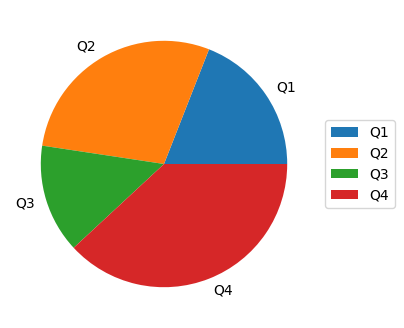

In [60]:
# get the data_owners rdf1 dataframe using its identifier
rdf1 = client.polars.get_df(RDF1)
rdf1.pieplot(parts="Sales", labels=["Q1", "Q2", "Q3", "Q4"])

connection.close()

Now data_scientist #2 is going to connect to the sever and view the number of elements in rdf3.

In [61]:
connection = Connection("localhost", identity=data_scientist_2)
client = connection.client

# get the data_owners rdf3 dataframe using its identifier
rdf3 = client.polars.get_df(RDF3)
rdf3.select(pl.col("Element").count()).collect().fetch()

Reason: Only 1 subrules matched but at least 2 are required.
Failed sub rules are:
Rule #1: Cannot fetch a DataFrame that does not aggregate at least 10 rows of the initial dataframe uploaded by the data owner.

A notification has been sent to the data owner. The request will be pending until the data owner accepts or denies it or until timeout seconds elapse.
The query has been accepted by the data owner.


Element
u32
1


In [ ]:
connection.close()

### Querying the security log

So let's now go back to our data owner. And imagine we now want to know what actions have been taken specifically on rdf1.

We can filter the security log to show only the entries where the input id is rdf1's id. Now we can see the fetches and queries ran by data scientist #1 when they launched the pie function.

In [62]:
connection = Connection("localhost", identity=data_owner)
client = connection.client

# get security log
rdf4 = client.polars.get_df("0000-0000-0000-0000")
rdf4.filter(pl.col("Inputs") == RDF1).collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""ba86c3e6e296c2...","""2022-12-20 17:...","""Run""","""5bd49a38-7834-...","""4e0da1ed-0a39-...","""[{""EntryPointP...","""n/a"""
"""ba86c3e6e296c2...","""2022-12-20 17:...","""Run""","""5bd49a38-7834-...","""4e0da1ed-0a39-...","""[{""EntryPointP...","""n/a"""


Similarly, we can see the query and fetch actions taken by datascientist #2 when we filter our results down to those taken on rdf3. The user hash has now changed to reflect that of data_scientist_2.

In [63]:
rdf4.filter(pl.col("Inputs") == RDF3).collect().fetch()

User,Time,Type,Inputs,Output,CompositePlan,PolicyViolation
str,str,str,str,str,str,str
"""b65435be4e242a...","""2022-12-20 17:...","""Run""","""5b93dc32-a226-...","""aeb7844e-3649-...","""[{""EntryPointP...","""n/a"""
"""b65435be4e242a...","""2022-12-20 17:...","""Run""","""5b93dc32-a226-...","""aeb7844e-3649-...","""[{""EntryPointP...","""n/a"""


That brings us to the end of our introduction to security logging in BastionLab. We can now close our connection to the server.

In [64]:
connection.close()